In [176]:
import glob
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

traffic_path = '../../SmartCity-master/traffic\\'
daily_folder = "daily"
separator = ';'
date_column = 'Dátum'


def read_all_traffic_daily():
    path = "D:/Szakdolgozat/SmartCity-master/traffic/AP1/daily/"
    all_files = glob.glob(path + "/*.csv")

    csvs = []

    for file in all_files:
        csvs.append(pd.read_csv(file, sep=separator, index_col=None, header=0))

    return convert_to_date(pd.concat(csvs, axis=0, ignore_index=True))

weather_separator = ','
weather_date_column = 'datum'

def read_all_weather():
    path = "D:/Szakdolgozat/SmartCity-master/weather/Janostol/"
    all_files = glob.glob(path + "/*.csv")

    csvs = []

    for file in all_files:
        csvs.append(pd.read_csv(file, sep=weather_separator, index_col=None, header=0))

    return weather_convert_to_date(pd.concat(csvs, axis=0, ignore_index=True))


def convert_to_date(data):
    data[date_column] = pd.to_datetime(data[date_column]).dt.date
    return data

def weather_convert_to_date(data):
    data[weather_date_column] = pd.to_datetime(data[weather_date_column]).dt.date
    return data


In [177]:
wdf = read_all_weather()
wdf = wdf[(wdf[weather_date_column] >= pd.to_datetime("2020-02-23")) & (wdf[weather_date_column] <= pd.to_datetime("2020-09-09"))]
wdf.rename(columns={'datum': 'Dátum'}, inplace=True)
wdf = wdf[wdf['telepules'] == 'k']
wdf = wdf.drop(wdf[wdf['atlaghom.'] == "-"].index)
wdf['atlaghom.'] = wdf['atlaghom.'].astype(float)
wdf = wdf.groupby(date_column, as_index=False)['atlaghom.'].mean()
wdf

,Dátum,atlaghom.
0,2020-02-23,7.968056
1,2020-02-24,8.260417
2,2020-02-25,8.598611
3,2020-02-26,7.462500
4,2020-02-27,4.397222
...,...,...
195,2020-09-05,20.062500
196,2020-09-06,22.062500
197,2020-09-07,22.227778
198,2020-09-08,18.440972


In [178]:
df = read_all_traffic_daily()
df = pd.merge(df, wdf[['Dátum', 'atlaghom.']], on=['Dátum'], how='inner')
df.sort_values('Irány 0 - Autók számossága', ascending=True).head(15)

,Dátum,Irány 0 - Autók számossága,Irány 1 - Autók számossága,Irány 0 - Biciklisek számossága,Irány 1 - Biciklisek számossága,Irány 0 - Gyalogosok számossága,Irány 1 - Gyalogosok számossága,Irány 0 - Buszok számossága,Irány 1 - Buszok számossága,Irány 0 - Trolik számossága,Irány 1 - Trolik számossága,atlaghom.
42,2020-04-05,18,35,9,5,6,1,0,2,0,0,12.167361
7,2020-03-01,285,379,14,41,24,49,4,10,1,2,8.756250
14,2020-03-08,528,587,31,49,115,69,2,11,1,2,6.222917
49,2020-04-13,2767,2564,651,867,662,241,215,319,96,119,16.884028
198,2020-09-09,2862,1668,466,324,514,127,223,231,68,60,18.862937
48,2020-04-12,2950,2658,807,1058,647,348,238,370,103,89,13.455245
35,2020-03-29,3113,2761,625,911,759,268,249,354,139,116,11.141667
28,2020-03-22,3284,2971,243,361,362,172,253,390,119,106,3.553472
46,2020-04-10,3475,3389,755,1039,690,322,258,369,118,97,14.480420
55,2020-04-19,3627,3389,539,746,621,208,258,365,71,110,15.335417


In [179]:
df = df.sort_values('Irány 0 - Autók számossága', ascending=True).iloc[6:]
df = df.sort_values('Dátum', ascending=True)

In [180]:
df['DayOfWeek'] = pd.DatetimeIndex(df[date_column]).dayofweek

df['Monday'] = df['DayOfWeek'] == 0
df['Tuesday'] = df['DayOfWeek'] == 1
df['Wednesday'] = df['DayOfWeek'] == 2
df['Thursday'] = df['DayOfWeek'] == 3
df['Friday'] = df['DayOfWeek'] == 4
df['Saturday'] = df['DayOfWeek'] == 5
df['Sunday'] = df['DayOfWeek'] == 6

df['Curfew'] = (df[date_column] >= pd.to_datetime("2020-03-28")) & (df[date_column] <= pd.to_datetime("2020-05-04"))
df['Holiday'] = (df[date_column] == pd.to_datetime("2020-03-15")) | (df[date_column] == pd.to_datetime("2020-04-10")) | (df[date_column] == pd.to_datetime("2020-04-12")) | (df[date_column] == pd.to_datetime("2020-04-13")) | (df[date_column] == pd.to_datetime("2020-05-01")) | (df[date_column] == pd.to_datetime("2020-05-31")) | (df[date_column] == pd.to_datetime("2020-06-01")) | (df[date_column] == pd.to_datetime("2020-08-20")) | (df[date_column] == pd.to_datetime("2020-10-23")) | (df[date_column] == pd.to_datetime("2020-11-01"))
df['Weekend'] = (pd.DatetimeIndex(df[date_column]).dayofweek >= 5)

df['Education'] =  ((df[date_column] >= pd.to_datetime("2020-01-01")) & (df[date_column] <= pd.to_datetime("2020-03-13"))) | ((df[date_column] >= pd.to_datetime("2020-09-01")) & (df[date_column] <= pd.to_datetime("2020-10-22"))) | ((df[date_column] >= pd.to_datetime("2020-11-02")) & (df[date_column] <= pd.to_datetime("2020-12-18")))
df['Education'] =  (df['Education'] == True) & (df['Weekend'] == False) & (df['Holiday'] == False)

df['DigitalEducation'] = ((df[date_column] >= pd.to_datetime("2020-03-16")) & (df[date_column] <= pd.to_datetime("2020-04-08"))) | (df[date_column] >= pd.to_datetime("2020-04-15")) & (df[date_column] <= pd.to_datetime("2020-06-16"))
df['DigitalEducation'] = (df['DigitalEducation'] == True) & (df['Weekend'] == False)

In [181]:
df.head(50)

,Dátum,Irány 0 - Autók számossága,Irány 1 - Autók számossága,Irány 0 - Biciklisek számossága,Irány 1 - Biciklisek számossága,Irány 0 - Gyalogosok számossága,Irány 1 - Gyalogosok számossága,Irány 0 - Buszok számossága,Irány 1 - Buszok számossága,Irány 0 - Trolik számossága,...,Wednesday,Thursday,Friday,Saturday,Sunday,Curfew,Holiday,Weekend,Education,DigitalEducation
0,2020-02-23,6445,6292,348,466,929,483,225,321,100,...,False,False,False,False,True,False,False,True,False,False
1,2020-02-24,10278,10232,1011,816,1146,615,638,752,240,...,False,False,False,False,False,False,False,False,True,False
2,2020-02-25,10421,10542,1377,1114,1309,807,798,910,284,...,False,False,False,False,False,False,False,False,True,False
3,2020-02-26,10397,10526,787,867,1206,400,620,814,177,...,True,False,False,False,False,False,False,False,True,False
4,2020-02-27,10479,10507,921,1066,1494,655,596,786,221,...,False,True,False,False,False,False,False,False,True,False
5,2020-02-28,11209,11394,603,792,1075,425,674,813,173,...,False,False,True,False,False,False,False,False,True,False
6,2020-02-29,8693,8548,554,628,1020,670,346,451,140,...,False,False,False,True,False,False,False,True,False,False
8,2020-03-02,10084,10017,948,1015,1129,450,714,788,207,...,False,False,False,False,False,False,False,False,True,False
9,2020-03-03,10240,10737,832,1053,1115,462,705,867,230,...,False,False,False,False,False,False,False,False,True,False
10,2020-03-04,10581,10735,539,612,767,295,679,775,218,...,True,False,False,False,False,False,False,False,True,False


<AxesSubplot:xlabel='Irány 1 - Autók számossága', ylabel='Count'>

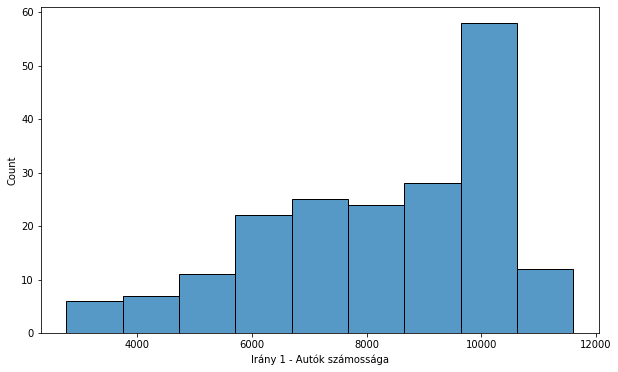

In [182]:
plt.figure(figsize=(10,6))
sns.histplot(df['Irány 1 - Autók számossága'])

In [183]:
df.corr()['Irány 0 - Autók számossága'].sort_values

<bound method Series.sort_values of Irány 0 - Autók számossága         1.000000
Irány 1 - Autók számossága         0.987150
Irány 0 - Biciklisek számossága    0.659828
Irány 1 - Biciklisek számossága    0.601741
Irány 0 - Gyalogosok számossága    0.763199
Irány 1 - Gyalogosok számossága    0.474639
Irány 0 - Buszok számossága        0.801472
Irány 1 - Buszok számossága        0.720901
Irány 0 - Trolik számossága        0.604519
Irány 1 - Trolik számossága        0.654061
atlaghom.                          0.388846
DayOfWeek                         -0.397101
Monday                             0.101862
Tuesday                            0.110317
Wednesday                          0.123539
Thursday                           0.131704
Friday                             0.188443
Saturday                          -0.202560
Sunday                            -0.475514
Curfew                            -0.582562
Holiday                           -0.308723
Weekend                           -0.517

In [184]:
df.head(20)

,Dátum,Irány 0 - Autók számossága,Irány 1 - Autók számossága,Irány 0 - Biciklisek számossága,Irány 1 - Biciklisek számossága,Irány 0 - Gyalogosok számossága,Irány 1 - Gyalogosok számossága,Irány 0 - Buszok számossága,Irány 1 - Buszok számossága,Irány 0 - Trolik számossága,...,Wednesday,Thursday,Friday,Saturday,Sunday,Curfew,Holiday,Weekend,Education,DigitalEducation
0,2020-02-23,6445,6292,348,466,929,483,225,321,100,...,False,False,False,False,True,False,False,True,False,False
1,2020-02-24,10278,10232,1011,816,1146,615,638,752,240,...,False,False,False,False,False,False,False,False,True,False
2,2020-02-25,10421,10542,1377,1114,1309,807,798,910,284,...,False,False,False,False,False,False,False,False,True,False
3,2020-02-26,10397,10526,787,867,1206,400,620,814,177,...,True,False,False,False,False,False,False,False,True,False
4,2020-02-27,10479,10507,921,1066,1494,655,596,786,221,...,False,True,False,False,False,False,False,False,True,False
5,2020-02-28,11209,11394,603,792,1075,425,674,813,173,...,False,False,True,False,False,False,False,False,True,False
6,2020-02-29,8693,8548,554,628,1020,670,346,451,140,...,False,False,False,True,False,False,False,True,False,False
8,2020-03-02,10084,10017,948,1015,1129,450,714,788,207,...,False,False,False,False,False,False,False,False,True,False
9,2020-03-03,10240,10737,832,1053,1115,462,705,867,230,...,False,False,False,False,False,False,False,False,True,False
10,2020-03-04,10581,10735,539,612,767,295,679,775,218,...,True,False,False,False,False,False,False,False,True,False


In [185]:
#df[df['Education'] == True]

<AxesSubplot:xlabel='Irány 0 - Autók számossága', ylabel='Irány 0 - Gyalogosok számossága'>

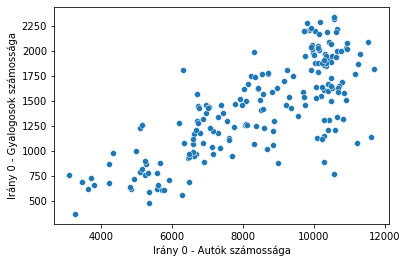

In [186]:
sns.scatterplot(x='Irány 0 - Autók számossága', y='Irány 0 - Gyalogosok számossága', data=df)

<AxesSubplot:xlabel='DayOfWeek', ylabel='Irány 0 - Autók számossága'>

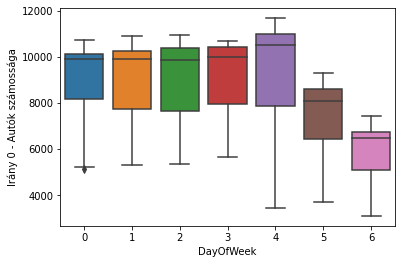

In [187]:
sns.boxplot(x='DayOfWeek', y='Irány 0 - Autók számossága', data=df)

In [384]:
X = df[['atlaghom.', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Curfew', 'DigitalEducation', 'Education', 'Weekend', 'Holiday']].values
y = df['Irány 1 - Gyalogosok számossága'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [385]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [386]:
model = Sequential()

model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))
model.add(Dense(13, activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [387]:
model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=3000, callbacks=[early_stop])

Train on 135 samples, validate on 58 samples
Epoch 1/3000
135/135 [==============================] - 0s 4ms/sample - loss: 304229.2590 - val_loss: 293935.8211
Epoch 2/3000
135/135 [==============================] - 0s 66us/sample - loss: 304204.8926 - val_loss: 293909.5593
Epoch 3/3000
135/135 [==============================] - 0s 66us/sample - loss: 304175.8708 - val_loss: 293874.6336
Epoch 4/3000
135/135 [==============================] - 0s 66us/sample - loss: 304137.9817 - val_loss: 293831.7263
Epoch 5/3000
135/135 [==============================] - 0s 66us/sample - loss: 304091.3766 - val_loss: 293779.0916
Epoch 6/3000
135/135 [==============================] - 0s 66us/sample - loss: 304034.1692 - val_loss: 293712.1336
Epoch 7/3000
135/135 [==============================] - 0s 59us/sample - loss: 303959.9197 - val_loss: 293624.1864
Epoch 8/3000
135/135 [==============================] - 0s 66us/sample - loss: 303860.1197 - val_loss: 293504.2209
Epoch 9/3000
135/135 [==============

135/135 [==============================] - 0s 59us/sample - loss: 18982.7489 - val_loss: 16910.9390
Epoch 73/3000
135/135 [==============================] - 0s 66us/sample - loss: 19120.7696 - val_loss: 17068.4826
Epoch 74/3000
135/135 [==============================] - 0s 66us/sample - loss: 19071.9272 - val_loss: 16691.9636
Epoch 75/3000
135/135 [==============================] - 0s 59us/sample - loss: 18723.8389 - val_loss: 16602.1530
Epoch 76/3000
135/135 [==============================] - 0s 59us/sample - loss: 18608.3473 - val_loss: 16556.2793
Epoch 77/3000
135/135 [==============================] - 0s 66us/sample - loss: 18578.7875 - val_loss: 16402.6318
Epoch 78/3000
135/135 [==============================] - 0s 59us/sample - loss: 18339.0462 - val_loss: 16348.4918
Epoch 79/3000
135/135 [==============================] - 0s 66us/sample - loss: 18227.6193 - val_loss: 16250.6669
Epoch 80/3000
135/135 [==============================] - 0s 59us/sample - loss: 18121.8053 - val_loss:

135/135 [==============================] - 0s 59us/sample - loss: 16045.6561 - val_loss: 14764.7782
Epoch 144/3000
135/135 [==============================] - 0s 66us/sample - loss: 16025.0998 - val_loss: 14800.3915
Epoch 145/3000
135/135 [==============================] - 0s 62us/sample - loss: 16001.6474 - val_loss: 14755.0537
Epoch 146/3000
135/135 [==============================] - 0s 66us/sample - loss: 15993.6855 - val_loss: 14794.3993
Epoch 147/3000
135/135 [==============================] - 0s 66us/sample - loss: 15935.0788 - val_loss: 15062.0700
Epoch 148/3000
135/135 [==============================] - 0s 66us/sample - loss: 16179.0565 - val_loss: 15041.5193
Epoch 149/3000
135/135 [==============================] - 0s 57us/sample - loss: 16188.0363 - val_loss: 14831.1699
Epoch 150/3000
135/135 [==============================] - 0s 66us/sample - loss: 15848.9543 - val_loss: 14660.3373
Epoch 151/3000
135/135 [==============================] - 0s 59us/sample - loss: 16015.2987 - v

<AxesSubplot:>

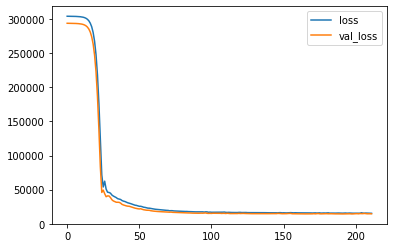

In [388]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [389]:
predictions = model.predict(X_test)

C:\Users\Zsombor\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


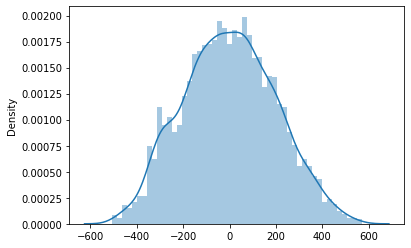

In [390]:
sns.distplot((y_test-predictions),bins=50);

In [391]:
np.sqrt(mean_squared_error(y_test, predictions))

120.60259240877005

In [392]:
mean_absolute_error(y_test, predictions)

97.39937039079338

In [393]:
explained_variance_score(y_test, predictions)

0.44343178867071176

In [394]:
test_predictions = model.predict(X_test)
test_predictions = pd.Series(test_predictions.reshape(58,))
pred_df = pd.DataFrame(y_test, columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

<AxesSubplot:xlabel='Test True Y', ylabel='Model Predictions'>

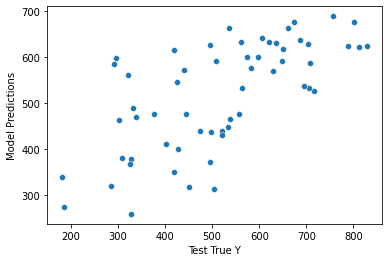

In [395]:
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

In [396]:
mean_absolute_error(pred_df['Test True Y'], pred_df['Model Predictions'])

97.39937039079338

In [397]:
df.describe()

,Irány 0 - Autók számossága,Irány 1 - Autók számossága,Irány 0 - Biciklisek számossága,Irány 1 - Biciklisek számossága,Irány 0 - Gyalogosok számossága,Irány 1 - Gyalogosok számossága,Irány 0 - Buszok számossága,Irány 1 - Buszok számossága,Irány 0 - Trolik számossága,Irány 1 - Trolik számossága,atlaghom.,DayOfWeek
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,8427.196891,8267.839378,1248.367876,1362.134715,1430.031088,520.450777,485.233161,579.383420,153.196891,166.202073,16.630904,2.958549
std,2111.760564,2046.653974,515.497913,424.548881,472.810016,174.456534,177.712879,189.404517,53.761361,46.886450,6.463538,1.978621
min,3113.000000,2761.000000,243.000000,361.000000,362.000000,144.000000,194.000000,286.000000,57.000000,82.000000,-0.038889,0.000000
25%,6751.000000,6776.000000,855.000000,1084.000000,1074.000000,382.000000,339.000000,410.000000,107.000000,128.000000,12.106944,1.000000
50%,8704.000000,8787.000000,1178.000000,1348.000000,1452.000000,505.000000,422.000000,521.000000,136.000000,155.000000,17.634028,3.000000
75%,10290.000000,10007.000000,1683.000000,1682.000000,1812.000000,649.000000,646.000000,741.000000,196.000000,206.000000,21.922143,5.000000
max,11689.000000,11607.000000,2560.000000,2194.000000,2340.000000,1111.000000,917.000000,1085.000000,298.000000,289.000000,27.287500,6.000000


In [398]:
mean_squared_error(pred_df['Test True Y'], pred_df['Model Predictions'])**0.5

120.60259240877005

In [399]:
#X = df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Curfew', 'DigitalEducation', 'Education', 'Weekend', 'Holiday']].values
new_data = [[10, False, False, False, False, False, False, True, True, False, False, True, False]]
new_data = scaler.transform(new_data)
model.predict(new_data)

array([[289.14078]], dtype=float32)

In [400]:
model.save('day_Újszeged_fele_gyalogosok.h5')
joblib.dump(scaler, 'day_Újszeged_fele_gyalogosok.pkl')

['day_Újszeged_fele_gyalogosok.pkl']

In [406]:
later_model = load_model('my_traffic_model_1.h5')

In [407]:
later_model.predict(new_data)

array([[3526.5698]], dtype=float32)

In [181]:
y = df['Irány 0 - Autók számossága']
X = df[['DayOfWeek', 'Curfew', 'DigitalEducation', 'Weekend']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [182]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [183]:
print('Coefficients: \n', lm.coef_)

Coefficients: 
 [  121.87502791 -2080.47901282 -1342.25974003 -3350.88327391]


Text(0, 0.5, 'Predicted Y')

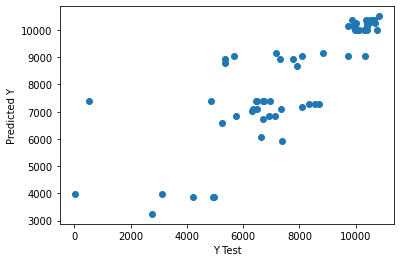

In [185]:
predictions = lm.predict( X_test)
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [186]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 952.7842493811964
MSE: 2299299.7446990656
RMSE: 1516.344203899321


C:\Users\Zsombor\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


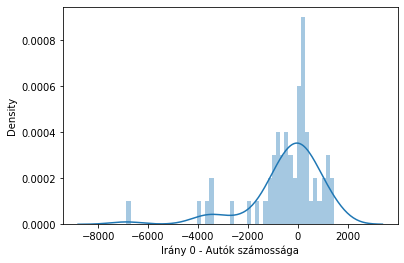

In [187]:
sns.distplot((y_test-predictions),bins=50)

In [188]:
coeffecients = pd.DataFrame(lm.coef_,X.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
DayOfWeek,121.875028
Curfew,-2080.479013
DigitalEducation,-1342.259740
Weekend,-3350.883274


In [189]:
lm.predict([[2, False, False, False]])


array([10262.99739613])